In [22]:
# TODO
# 1. Complete make_one_shot_task
# 2. Complete test one shot task
# 3. Complete plotting
# 4. See if using attention with some static probabilities help the detection of spoofing
# 5. Look at triple loss and computing it
# 6. CNN and attention to top of the book - https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6
    #Propose probabilities learnt through an LSTM network 
# 7. Higher prediction probabilities for top of book
    #https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# 8. Fuck with data to get the desired result -b rebuild project
# 9. Clean up code, make fancy plots, write comments and so on
# 10. See if using LSTM to learn probabilities for attention would work 
# 11. Learn Families of classes for spoofing 
# 12. Custom loss function for family of identifications
# 13. Cross Modal for price and qty - https://iclr.cc/virtual/poster_B1lJzyStvS.html
# 14. Mutual information for either layering or other task - https://iclr.cc/virtual/poster_rkxoh24FPH.html, https://openreview.net/forum?id=rkxoh24FPH
# 15. Time seires with triplet leraning - https://papers.nips.cc/paper/8713-unsupervised-scalable-representation-learning-for-multivariate-time-series.pdf
# 16. Quadraple Learning - https://www.youtube.com/watch?v=_o2SLgjejAE
# 17. Add 13/14/15/16 for the work
#. testing 

##### RESULTS
1. No-Change Unnormalised Loss : 0.012634731829166412
2. Normalised Loss without anchor normalisation : 0.5267388820648193
3. Normalised Loss with anchor : 0.20129983127117157

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
train_source = os.path.abspath(os.path.join('../../data/train_source/'))
test_source = os.path.abspath(os.path.join('../../data/test_source/'))
train_path = os.path.abspath(os.path.join('../../data/train/'))
test_path = os.path.abspath(os.path.join('../../data/test/'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
#print(device_lib.list_local_devices())

In [2]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
volume_imbalace = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
num_frames = 20
h = 30
w = 2
d = 2

In [3]:
def retrieve_cleansed_data(lob, width=num_frames):
    min_max_scaler = MinMaxScaler(feature_range=(0,50))
    quantile_transformer = QuantileTransformer()

    # As evidenced by above, we can technically select all in the second axis as there is only 1 element. However, 
    # because we need a 2d input we make it 0. The 3rd axis is side so we need this
    lob_qty_buy = pd.DataFrame(lob['quantity'][:,0,0,0:20])
    lob_qty_buy = lob_qty_buy.replace(0, np.NaN)
    avg_buy = lob_qty_buy.mean().mean()
    vol_sum_buy = lob_qty_buy.sum(axis=1)
    
    lob_qty_sell = pd.DataFrame(lob['quantity'][:,0,1,0:20])
    lob_qty_sell = lob_qty_sell.replace(0, np.NaN)
    avg_sell = lob_qty_sell.mean().mean()
    vol_sum_sell = lob_qty_sell.sum(axis=1)

    vol_imbalance = (vol_sum_buy - vol_sum_sell) / (vol_sum_buy + vol_sum_sell)
    
    avg_both_sides = (avg_buy + avg_sell) / 2
    lob_qty_buy_w = lob_qty_buy * avg_both_sides
    vol_sum_buy_w = lob_qty_buy_w.sum(axis=1)
    lob_qty_sell_w = lob_qty_sell * avg_both_sides
    vol_sum_sell_w = lob_qty_sell_w.sum(axis=1)
    
    weighted_vol_imbalance = (vol_sum_buy_w/(20*avg_both_sides)) - (vol_sum_sell_w/(20*avg_both_sides))
    
    # Imbalance tips. The only way this can happen is if a new order comes in or deletes. 
    
    label_df = pd.concat([vol_imbalance, pd.Series(lob['action'].ravel()), pd.Series(lob['side'].ravel())], axis=1)
    label_df[3] = label_df[0].diff() # Change in the values of the two states of OB (We take diff of prev row)
    label_df[4] = 0
    label_df[4] = np.where(((label_df[1] == 2) & (label_df[2] == 'B') & (np.abs(label_df[3]) > volume_imbalace)), 1, 
                  np.where(((label_df[1] == 2) & (label_df[2] == 'S') & (np.abs(label_df[3]) > volume_imbalace)), 2, 
                             label_df[4].values))
    label_df = label_df.iloc[width-1:]
    Y_labels = label_df[4].reset_index(drop=True)
    X_feature = np.abs(label_df[3]).reset_index(drop=True)
   
    # Normalise positive samples
    # these array manipulations are to get a final array where b-s in same array group
    lob_n, d, w, h = lob['quantity'].shape
    b_qty = lob['quantity'][:,0,0,:]
    s_qty = lob['quantity'][:,0,1,:]
    lob_qty = np.stack((b_qty, s_qty), axis=2)

    lob_qty = lob_qty.reshape(-1,1)
    lob_qty = min_max_scaler.fit_transform(lob_qty)
    lob_qty = lob_qty.reshape(lob_n, h, w)
    
    b_price = lob['price'][:,0,0,:]
    s_price = lob['price'][:,0,1,:]
    lob_price = np.stack((b_price, s_price), axis=2)

    lob_price = lob_price.reshape(-1,1)
    lob_price = quantile_transformer.fit_transform(lob_price)
    lob_price = lob_price.reshape(lob_n, h, w)

    lob_states = np.dstack((lob_qty, lob_price))
    lob_states = lob_states.reshape(lob_n, h, w, 2)
    lob_states = view_as_windows(lob_states,(width,1,1,1))[...,0,0,0].transpose(0,4,1,2,3)
    Y_labels = Y_labels[(Y_labels==1) | (Y_labels==2)]
    lob_states = lob_states[Y_labels.index]
    X_feature = X_feature[Y_labels.index]
    print(Y_labels.count())
    print(lob_states.shape)
    Y_labels = Y_labels.reset_index(drop=True)
    X_feature = X_feature.reset_index(drop=True)
    #print(Y_labels.type)
    return lob_states, Y_labels, X_feature

### Validation of Cleansed Data

In [ ]:
lob_t, y_t = retrieve_cleansed_data(dataset)

sell_side_label = y_t[y_t == 2]
buy_side_label = y_t[y_t == 1]
print(sell_side_label.count())
print(buy_side_label.count())
print(sell_side_label.index)

### Data Loading and Cleansing

In [4]:
def convert_data_to_labels(data_source):
    X = None
    Y = None
    W = None
    for subdir, dirs, files in os.walk(data_source):
        for file in files:
            data_path = os.path.join(subdir, file)
            print(data_path)
            npy = np.load(data_path)
            x, y, weight = retrieve_cleansed_data(npy)
            if X is not None:
                X = np.append(X, x, axis=0)
            else:
                X = x
                
            if Y is not None:
                Y = Y.append(y)
            else:
                Y = y
                
            if W is not None:
                W = W.append(weight)
            else:
                W = weight
            print(X.shape)
    return X, Y, W

In [5]:
X_train, Y_train, X_feature = convert_data_to_labels(train_source)

/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/train_source/IBM_NASDAQ.npy
4930
(4930, 20, 30, 2, 2)
(4930, 20, 30, 2, 2)
/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/train_source/GOOG_NASDAQ.npy
2821
(2821, 20, 30, 2, 2)
(7751, 20, 30, 2, 2)
/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/train_source/VOD_EDGX.npy
5030
(5030, 20, 30, 2, 2)
(12781, 20, 30, 2, 2)
/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/train_source/SPY_NASDAQ.npy
32786
(32786, 20, 30, 2, 2)
(45567, 20, 30, 2, 2)
/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/train_source/GOOG_BATS.npy
770
(770, 20, 30, 2, 2)
(46337, 20, 30, 2, 2)


In [6]:
X_test, Y_test, X_test_feature = convert_data_to_labels(test_source)

/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/test_source/VOD_NASDAQ.npy
11434
(11434, 20, 30, 2, 2)
(11434, 20, 30, 2, 2)
/rds/general/user/kk2219/home/LimitOrderBookPatterns/data/test_source/VOD_BATS.npy
7755
(7755, 20, 30, 2, 2)
(19189, 20, 30, 2, 2)


In [7]:
Y_train = Y_train.reset_index(drop=True)
X_feature = X_feature.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
X_test_feature = X_test_feature.reset_index(drop=True)

### Run this When Experimenting ONLY

In [ ]:
train = np.load(project_path + '/data/train_source/SPY_NASDAQ.npy')
test = np.load(project_path + '/data/test_source/VOD_BATS.npy')
X_train, Y_train, X_feature = retrieve_cleansed_data(train)
X_test, Y_test, X_test_feature = retrieve_cleansed_data(test)
#print(X_train[0])

### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

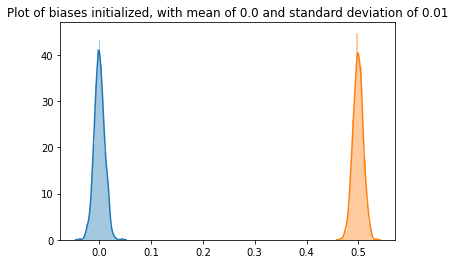

In [8]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [9]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs

        hardest_positive_dist = tf.reduce_max(tf.square(tf.subtract(anchor, positive)), axis=-1)
        tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

        # shape (batch_size)
        hardest_negative_dist = tf.reduce_min(tf.subtract(anchor, negative), axis=-1)
        tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))
    
        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + self.alpha, 0.0)
        # Get final mean triplet loss
        triplet_loss = tf.reduce_mean(triplet_loss)
        return triplet_loss
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [10]:
def triplet_loss(inputs):
        anchor, positive, negative = inputs

        hardest_positive_dist = tf.reduce_max(tf.square(tf.subtract(anchor, positive)), axis=-1)
        tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

        # shape (batch_size)
        hardest_negative_dist = tf.reduce_min(tf.subtract(anchor, negative), axis=-1)
        tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))
    
        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + 0.2, 0.0)
        # Get final mean triplet loss
        triplet_loss = tf.reduce_mean(triplet_loss)
        return triplet_loss
    
def accuracy(y_true, y_pred):
    return K.mean(y_pred[:,0,0] < y_pred[:,1,0])

def l2Norm(x):
    return  K.l2_normalize(x, axis=-1)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 30, 2, 2)]    0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 20, 120)           0         
_________________________________________________________________
tcn_3 (TCN)                  (None, 128)               473984    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
Total params: 490,496
Trainable params: 490,496
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output 

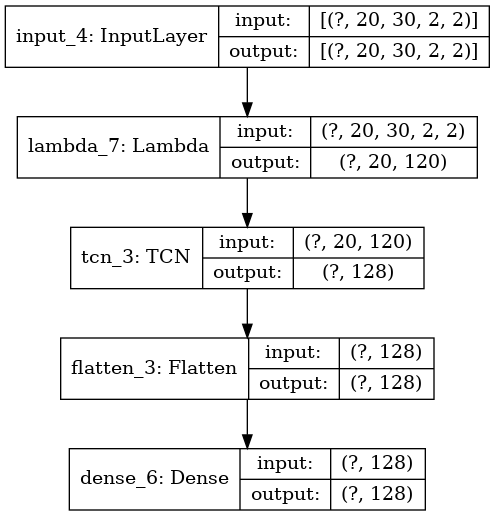

In [18]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)    
    return Model(inputs=inp, outputs=out)

def embedding_model_1(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=2, dropout_rate=0.02)(out)
    out = Flatten()(out)
    
    inp1 = Input(shape=(frames, h, w, c))
    out1 = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp1)
    num_features_cnn = np.prod(K.int_shape(out1)[1:])
    out1 = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp1)
    out1 = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.02)(out1)
    out1 = Flatten()(out1)
    
    # merge
    merged = concatenate([out, out1])
    
    out2 = Dense(60, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(merged)    
    return Model(inputs=inp, outputs=out2)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
   # positive_input = Input(shape=input_shape, name='positive_input')
   # negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    
   # encoded_p = embedding(positive_input)
   # encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
   # loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
  #  prediction = Dense(2,activation='sigmoid',bias_initializer=initialize_bias)(loss_layer)
     # The Lamda layer produces output using given function. Here its Euclidean distance.
   # positive_dist = Lambda(euclidean_distance, name='pos_dist')([encoded_a, encoded_p])
   # negative_dist = Lambda(euclidean_distance, name='neg_dist')([encoded_a, encoded_n])
   # tertiary_dist = Lambda(euclidean_distance, name='ter_dist')([encoded_p, encoded_n])

    # This lambda layer simply stacks outputs so both distances are available to the objective
   # stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([positive_dist, negative_dist, tertiary_dist])

    # Connect the inputs with the outputs
    prediction = Dense(1,activation='relu',bias_initializer=initialize_bias)(encoded_a)
    triplet_net = Model(inputs=[anchor_input],outputs=[prediction])
    
    return triplet_net

build_embedding = embedding_model(num_frames, 30, w, d, input_shape=(num_frames, 30, w, d), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, 30, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss='mse',optimizer=optimizer,sample_weight_mode="temporal", 
                      metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])
build_embedding.summary()
build_triplet.summary()
#print(build_triplet.metrics_names)
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

### Training Triplet Net

In [12]:
def get_triplet_batch_spoof(batch_size, lob_states, labels, features):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    feature_weight = [np.zeros(batch_size) for i in range(3)]
    class_labels = [np.zeros(batch_size) for i in range(3)]
    
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]

    for i in range(batch_size):
        if (i%2==0):
            idx_a = labels_b.sample(1).index
            idx_p = labels_b.sample(1).index
            idx_n = labels_s.sample(1).index
        else:
            idx_a = labels_s.sample(1).index
            idx_p = labels_s.sample(1).index
            idx_n = labels_b.sample(1).index
        
        feature_weight[0][i] = features[idx_a]
        feature_weight[1][i] = features[idx_p]
        feature_weight[2][i] = features[idx_n]
        
        class_labels[0][i] = labels[idx_a]
        class_labels[1][i] = labels[idx_p]
        class_labels[2][i] = labels[idx_n]
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]], [class_labels[0], class_labels[1], class_labels[2]], \
           [feature_weight[0], feature_weight[1], feature_weight[2]]

def get_triplet_batch_spoof_1(batch_size, lob_states, labels, features):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    feature_weight = [np.zeros(batch_size) for i in range(3)]
    class_labels = [np.zeros(batch_size) for i in range(3)]
    
    labels_u = labels[labels==0]
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]
    
   # print(labels_u.shape)
    #print(labels_b.shape)
    #print(labels_s.shape)
    for i in range(batch_size):
        if (i%5==0):
            idx_a = labels_b.sample(1).index
            idx_p = labels_b.sample(1).index
            idx_n = labels_s.sample(1).index
        elif (i%5==1):
            idx_a = labels_b.sample(1).index
            idx_p = labels_b.sample(1).index
            idx_n = labels_u.sample(1).index
        elif (i%5==2):
            idx_a = labels_s.sample(1).index
            idx_p = labels_s.sample(1).index
            idx_n = labels_b.sample(1).index
        elif (i%5==3):
            idx_a = labels_s.sample(1).index
            idx_p = labels_s.sample(1).index
            idx_n = labels_u.sample(1).index
        elif (i%5==4):
            idx_a = labels_u.sample(1).index
            idx_p = labels_u.sample(1).index
            idx_n = labels_b.sample(1).index
        else:
            idx_a = labels_u.sample(1).index
            idx_p = labels_u.sample(1).index
            idx_n = labels_s.sample(1).index
   
        
        feature_weight[0][i] = features[idx_a]
        feature_weight[1][i] = features[idx_p]
        feature_weight[2][i] = features[idx_n]
        
        class_labels[0][i] = labels[idx_a]
        class_labels[1][i] = labels[idx_p]
        class_labels[2][i] = labels[idx_n]
        
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]], [class_labels[0], class_labels[1], class_labels[2]]#, \
          # [feature_weight[0], feature_weight[1], feature_weight[2]]

#get_triplet_batch_spoof(1, X_train, Y_train, X_feature)

def triplet_generator_spoof(batch_size, X_train, Y_train, X_feature):
    while True:
        triplets, labels, features = get_triplet_batch_spoof(batch_size, X_train, Y_train, X_feature)
        yield (triplets, labels, features)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[  9.2667      29.408585    35.827026   -15.337895    19.933443
 -15.084097    26.629065   -10.196064    14.141822    19.394821
  11.152301   -40.58004    -23.680267   -17.752588    -3.2267246
  -5.5923195   32.76178     22.428576   -13.5010395  -18.704191
 -13.195376    26.838041   -25.121044    35.42085    -14.682497
 -23.125841   -13.178528    44.36793      6.4605293   14.245723
   

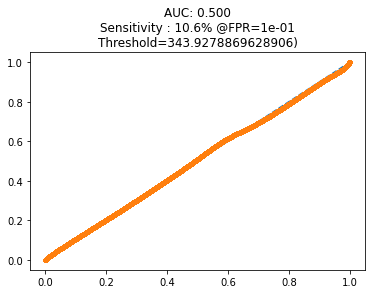

In [11]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    plt.show()
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    print(embeddings[1])
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test[:2000,:,:,:,:], Y_test[:2000])
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

In [19]:
build_triplet.fit(x=X_train, y=Y_train, batch_size=4, epochs=10, 
                verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
                          shuffle=True, class_weight=None, sample_weight=X_feature, initial_epoch=0, 
                          steps_per_epoch=200, validation_steps=None)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - 3s 15ms/step - loss: 0.6510 - mean_squared_error: 2.4728 - root_mean_squared_error: 1.5725
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6092 - mean_squared_error: 2.3509 - root_mean_squared_error: 1.5333
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6171 - mean_squared_e

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[-29.051632    -1.3363155   17.037706    -1.4707624   22.20921
 -12.596588   -15.150329   -15.802868    14.503093     2.902929
   2.7437308  -35.3186       6.8891926  -13.250541     3.0515726
   4.0881186    1.6144959  -17.745663     0.25203893  -5.2918644
   2.2532518    2.9893796   13.632109   -13.346342     1.5276134
 -18.763031    -1.1227218   -9.034953    -0.824651   -16.690817
  

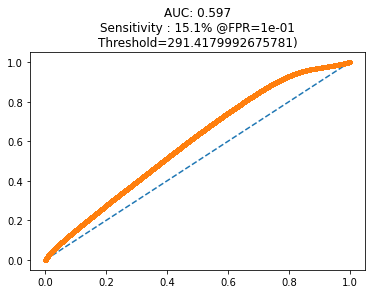

In [20]:
probs, yprob = compute_probs(build_embedding, X_test[:1500,:,:,:,:], Y_test[:1500])
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr, thresholds, auc)

Starting training process!!
-------------------------------------
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - 3s 15ms/step - loss: 0.6471
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6268
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6196
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0

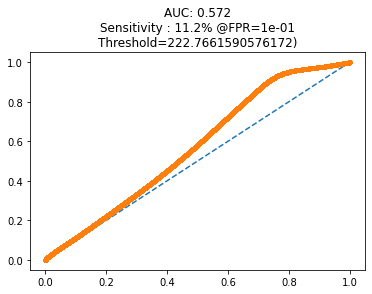

Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5819
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.6006
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5928
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5707
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.4843
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.4790
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.4461
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 0.4101
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.3954
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 0.3695
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.3604
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.3848
Epoch 3/10
200/

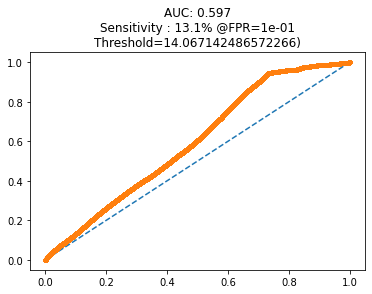

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.4002
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3316
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3211
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3123
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3205
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3244
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3139
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3050
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3135
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3104
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3084
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2890
Epoch 3/10
200/

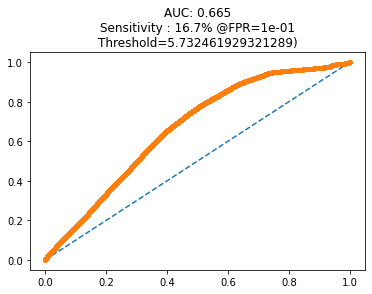

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2627
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2635
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2474
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2613
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2510
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2498
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2441
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2397
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2462
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2437
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2374
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2317
Epoch 3/10
200/

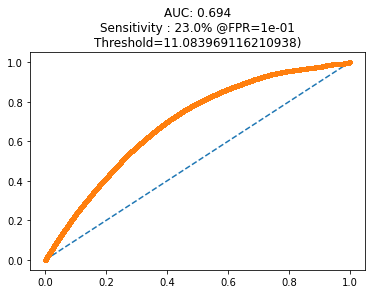

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2119
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2434
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2262
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2354
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2453
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2236
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2161
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2238
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2205
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2170
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2225
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2347
Epoch 3/10
200/

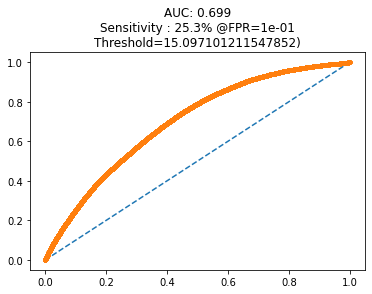

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2197
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2110
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1997
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2055
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2138
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2039
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1995
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2015
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1967
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1990
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1894
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1991
Epoch 3/10
200/

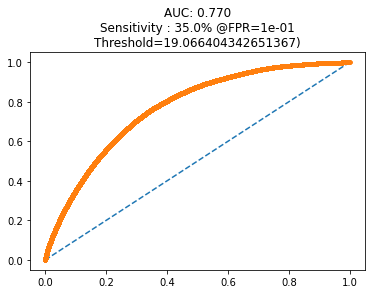

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1873
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1865
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1822
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1793
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1919
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1893
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1836
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1880
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1823
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1815
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1757
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1745
Epoch 3/10
200/

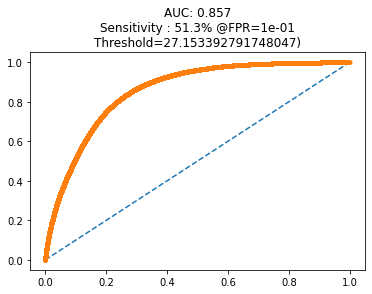

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1681
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1644
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1655
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1639
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1709
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1633
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1713
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1630
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1636
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1611
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1599
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1580
Epoch 3/10
200/

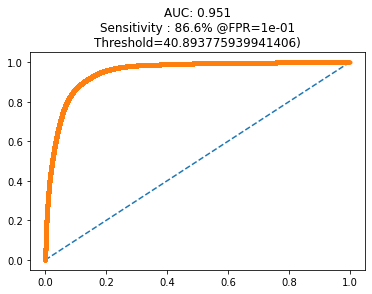

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1580
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1495
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1497
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1533
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1480
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1469
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1453
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1451
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1423
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1429
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1421
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1423
Epoch 3/10
200/

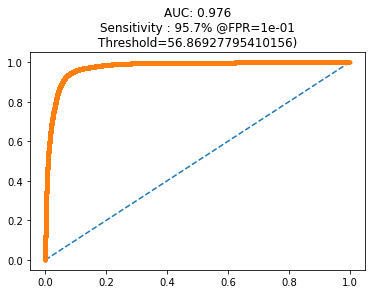

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1350
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1375
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1341
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1329
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1330
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1319
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1323
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1323
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1299
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1326
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1281
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1263
Epoch 3/10
200/

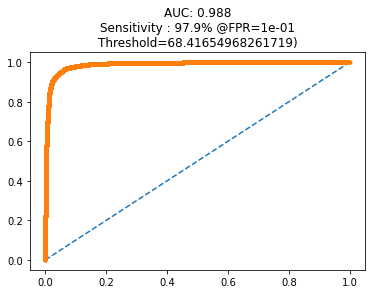

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1206
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1188
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1227
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1196
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1182
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1188
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1170
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1157
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1138
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1125
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1130
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1125
Epoch 3/10
200/

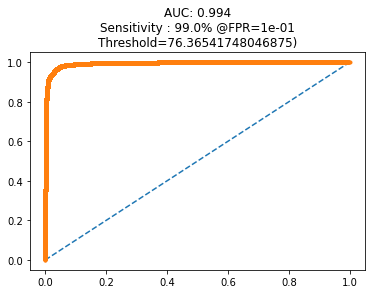

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1037
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1028
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1041
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1008
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1024
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1006
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1012
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0983
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0983
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0971
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0969
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0963
Epoch 3/10
200/

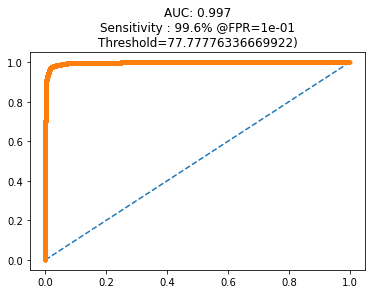

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0884
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0896
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0875
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0867
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0863
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0869
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0860
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0834
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0836
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0832
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0833
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0820
Epoch 3/10
200/

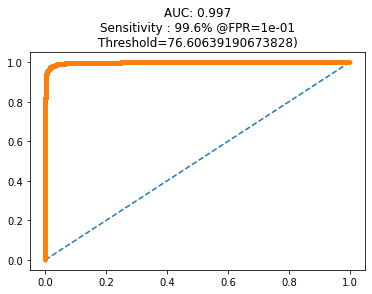

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0738
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0767
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0727
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0733
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0714
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0722
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0693
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0697
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0701
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0701
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0667
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0662
Epoch 3/10
200/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 15ms/step - loss: 0.0338
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0328
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0336
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0324

 ------------- 

[-0.49216804 -0.90828365  0.3107864  -1.5105641  -0.00123074 -0.38657567
 -0.8330575  -1.755477   -0.54850733  0.5752883   0.00000093  0.8191834
 -0.0010079   0.14099592  1.0522438  -0.83113766  0.2872931   1.2149998
  0.00040653 -1.4935943   0.8099913   1.2088902  -0.5231306   0.00629888
 -0.64851254 -0.63803136  0.03588237  1.6603587  -1.6211922  -0.57487386
  0.02422692 -1.3193021   0.30691427  0.39511904  0.00822494  0.609678
  1.6101321  -0.686135    1.1395707  -1.5546117  -0.17503843  0.47884986
  0.9667923  -0.517664    0.00651721 -0.33875835  0.92203546 -0.6779096
  0.25272742 -0.39183864  0.79982126  0.00041989 -0.45649952  0.98017657
 -0.6956488 

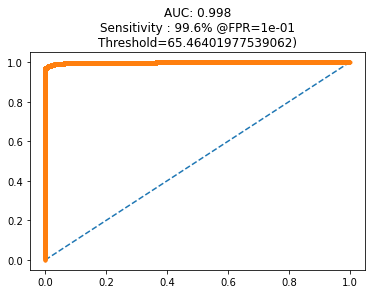

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0325
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0314
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0317
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0324
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0307
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0297
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0299
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0308
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0296
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0291
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0285
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0281
Epoch 3/10
200/

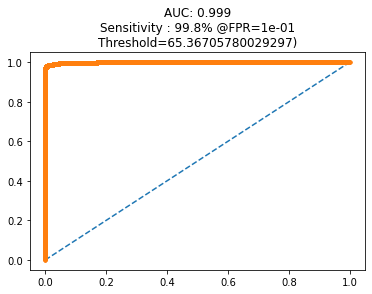

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0251
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0245
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0239
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0241
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0236
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0240
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0234
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0228
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0223
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0216
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0215
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0213
Epoch 3/10
200/

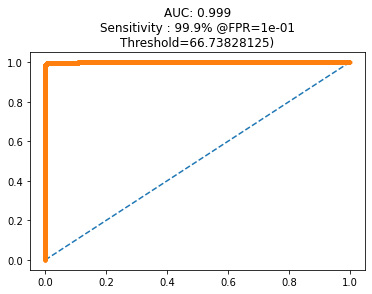

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0190
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0184
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0185
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0185
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0176
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0174
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0177
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0171
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0171
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0166
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0161
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0158
Epoch 3/10
200/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 16ms/step - loss: 0.0071
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0068
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0067
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0068
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0065
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0065
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0062

 ------------- 

[-0.3266138  -0.6922305   0.23707499 -0.89437664  0.00139085 -0.07060543
 -0.6403098  -1.4353164  -0.4989293   0.42141888 -0.02478955  0.21010873
 -0.00436453  0.12558259  0.82747895 -0.5293342   0.18106556  0.86537766
  0.00132456 -1.1644331   0.573955    0.66518545 -0.30097815 -0.00372389
 -0.5914279  -0.37164775  0.00306675  1.3583221  -1.1420108  -0.32513133
  0.00364381 -1.0166951   0.14098527  0.3200131  -0.0

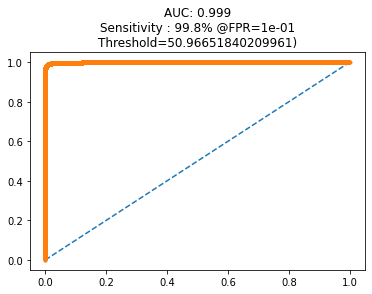

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0061
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0063
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0058
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0059
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0061
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0060
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0057
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0062
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0056
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0057
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0056
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0056
Epoch 3/10
200/

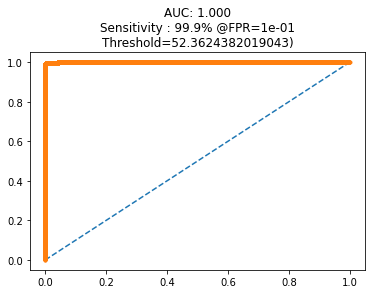

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0046
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0050
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0047
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0051
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0051
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0042
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0043
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0044
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0041
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0040
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0043
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0046
Epoch 3/10
200/

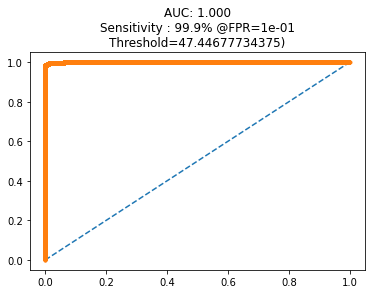

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0037
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0042
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0036
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0034
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0037
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0035
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0034
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0034
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0033
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0032
Epoch 1/10
120/200 [=================>............] - ETA: 1s - loss: 0.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



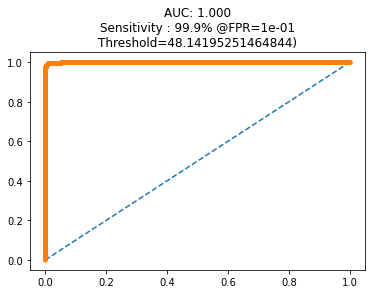

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0034
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0032
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0055
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 3/10
200/

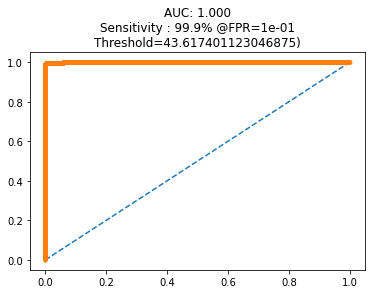

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0027
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0026
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0022
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0022
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0023
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0025
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0021
Epoch 3/10
200/

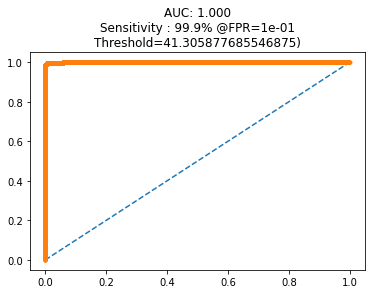

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0021
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0025
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0023
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0018
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0017
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0019
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0017
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0019
Epoch 3/10
200/

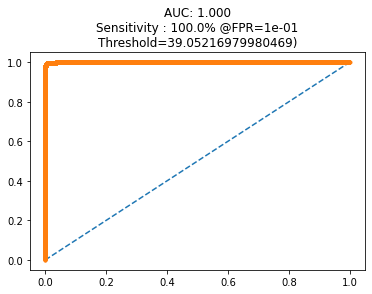

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0015
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0024
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0018
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0018
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0015
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0015
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 3/10
200/

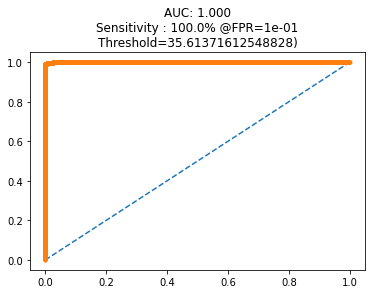

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0013
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0013
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0013
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0017
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0013
Epoch 3/10
200/

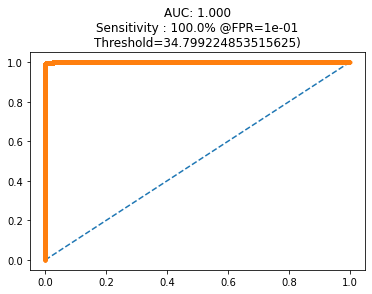

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0013
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0013
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0015
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 9.7340e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0013
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 9.3591e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0017
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0014
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 3

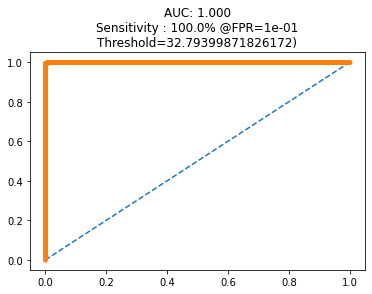

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0012
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 9.6942e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0012
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 9.2287e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 9.8403e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 9.2481e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0011
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0012
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0011
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0011

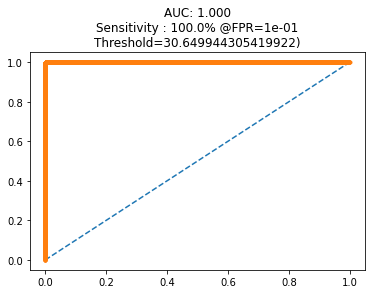

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 9.3949e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 8.1241e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 8.7837e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 8.0084e-04
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 7.6101e-04
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 9.0472e-04
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 8.7977e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 8.4210e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 7.9191e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 8.7138e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 7.5246e-04
Epoch 2/10
200/200 [==============================] -

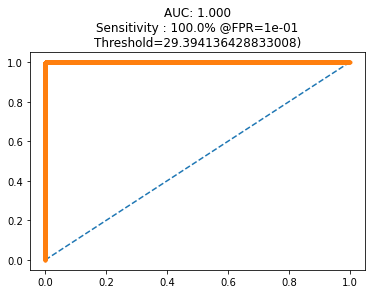

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 7.7307e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 7.2646e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 7.4770e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 9.3771e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 8.6577e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 6.1075e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 8.0680e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 7.6111e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0012
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 6.8062e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms

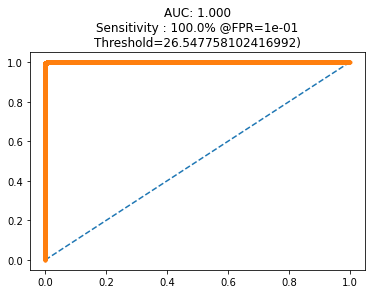

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 6.4030e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 5.6729e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 6.8547e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 9.7081e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0011
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0011
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 5.4417e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0010
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 8.7410e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.2534e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - 

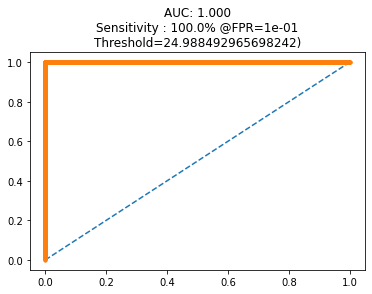

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 7.1916e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 7.7671e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 5.0944e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 6.2135e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 6.1879e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 7.7955e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 5.7098e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 7.2286e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0022
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 6.4189e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 5.9518e-04
Epoch 2/10
200/200 [==============================] - 3s 

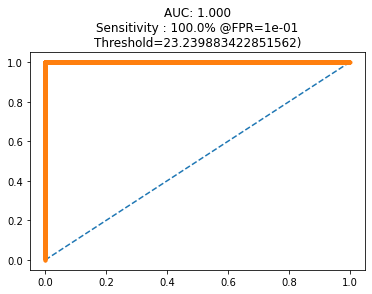

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 7.5449e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 4.9526e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 4.0547e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 5.5134e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 4.9421e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 5.0160e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 5.7229e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 6.6513e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 5.2674e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 4.3641e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 7.2604e-04
Epoch 2/10
200/200 [==============================] -

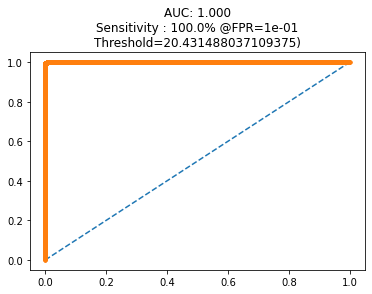

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.0757e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6714e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 5.3341e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 6.5851e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 5.6722e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 4.0717e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 5.5328e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.9270e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 8.2014e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 4.8464e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 4.5876e-04
Epoch 2/10
200/200 [==============================] -

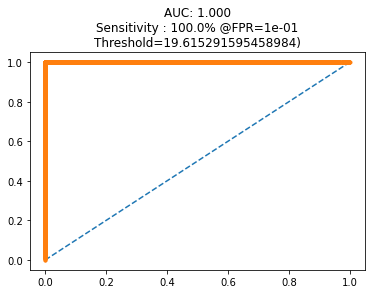

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 6.0644e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.3489e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5868e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 4.2921e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.2450e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 4.9968e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 4.6940e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6060e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 5.1440e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5502e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.2246e-04
Epoch 2/10
200/200 [==============================] -

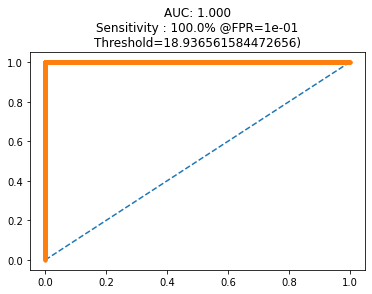

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.4948e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7909e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 4.9969e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7268e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.0901e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 5.2467e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 6.1095e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1956e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6242e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 5.2748e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.7001e-04
Epoch 2/10
200/200 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



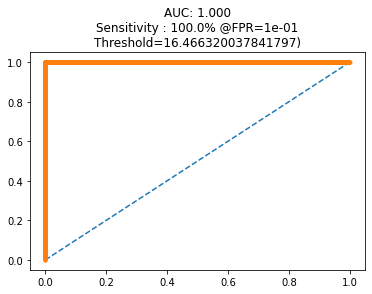

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7317e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 4.6809e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 4.4338e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 3.8919e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 4.7052e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5535e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7326e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0167e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4505e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 3.0727e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.6697e-04
Epoch 2/10
200/200 [==============================] -

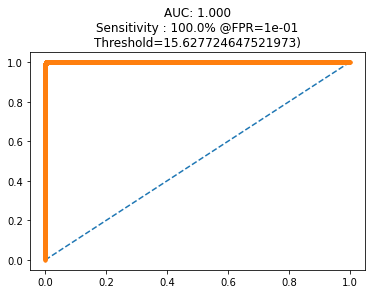

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 4.0769e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.0224e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9672e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5607e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1396e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5310e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5741e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 4.1978e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 3.4014e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4608e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 6.5170e-04
Epoch 2/10
200/200 [==============================] -

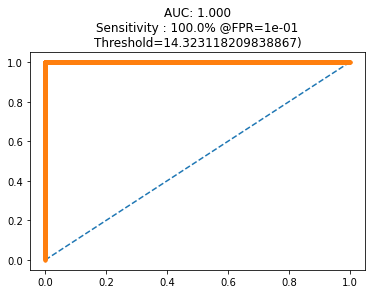

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 4.7582e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5205e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 4.1817e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7606e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1842e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0512e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1569e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9486e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0443e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7242e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 4.0071e-04
Epoch 2/10
200/200 [==============================] -

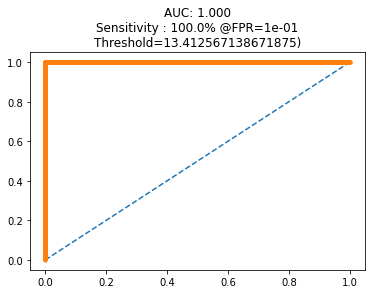

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9122e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 5.0644e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 4.2868e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 4.7685e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 4.4588e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 4.7366e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 1.9020e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.7557e-04
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 2.9695e-04
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 2.3243e-04
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9680e-04
Epoch 2/10
200/200 [==============================] -

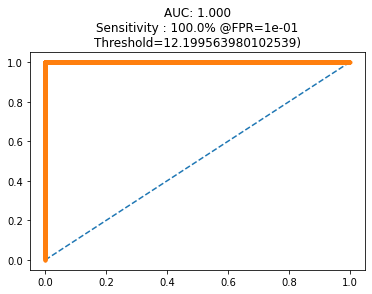

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 4.1262e-04
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 1.8936e-04
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 6.0929e-04
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 3.0335e-04
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 3.9139e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7396e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4094e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 4.0085e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1079e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0461e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.3988e-04
Epoch 2/10
200/200 [==============================] -

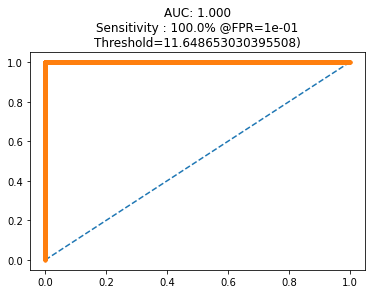

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9729e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6523e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3246e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 3.8256e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.4527e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4864e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 3.0452e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.5191e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.9213e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 5.0906e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.2502e-04
Epoch 2/10
200/200 [==============================] -

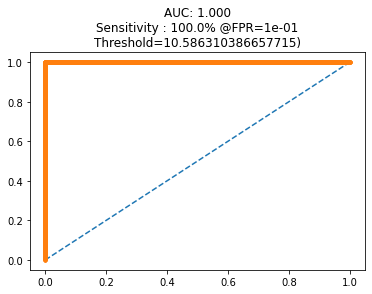

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6477e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.0451e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3406e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2100e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.1758e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4790e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2571e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7220e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6445e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 3.0863e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 4.3003e-04
Epoch 2/10
200/200 [==============================] -

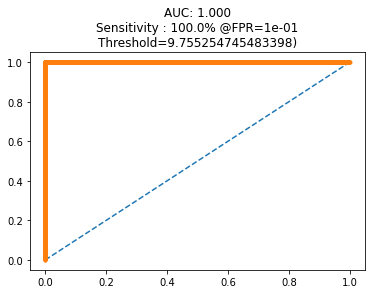

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6449e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5824e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4574e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2761e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9730e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6638e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4665e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1364e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8904e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4528e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1075e-04
Epoch 2/10
200/200 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 14ms/step - loss: 3.8312e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0869e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2789e-04

 ------------- 

[-0.00009961 -0.158939    0.00195619  0.01711691  0.00064699  0.00052764
  0.08779141 -0.3767534  -0.18353167 -0.04302188  0.10440458 -0.00036904
  0.00019937 -0.09864409 -0.02590659 -0.24420546 -0.11150412  0.07452614
  0.00091851  0.0366824   0.10958323  0.00036621 -0.11833157 -0.07543776
  0.01636507  0.00017074  0.00006165  0.268408    0.0925797   0.09905451
 -0.00005314 -0.05511385  0.06502579  0.07906671  0.00050257  0.09914617
  0.3990077  -0.12469595  0.27806282 -0.12665473  0.10119814  0.12111484
  0.18260817  0.00054193  0.00053112  0.10168051 -0.06250176 -0.04410478
  0.00056729  0.07537263 -0.08102928  0.00005019  0.05352506 -0.00043968
 -0.00005155  0.07649675 -0.09432012  0.00090978 -0.25081682 -0.17116992
  0.

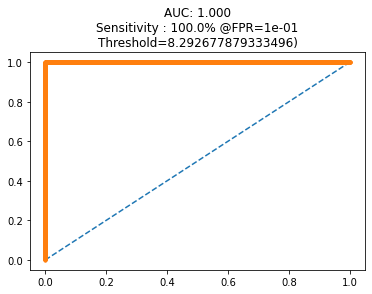

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.1287e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 1.1354e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 4.0258e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 9.8833e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 1.2380e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0637e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6747e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 9.9895e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 4.2924e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4609e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 8.3740e-05
Epoch 2/10
200/200 [==============================] -

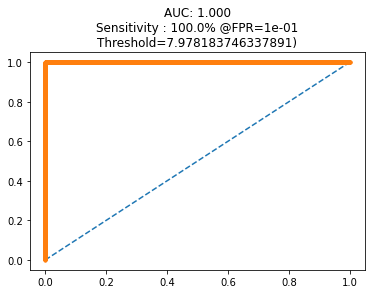

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.3497e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 4.3256e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0450e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5011e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.9506e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.5899e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8833e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0691e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 4.0940e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3262e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9845e-04
Epoch 2/10
200/200 [==============================] -

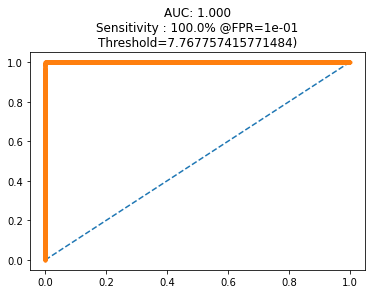

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.6807e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 8.6353e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 1.3084e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8109e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0761e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0761e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 8.8445e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8977e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8985e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 1.1793e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5165e-04
Epoch 2/10
200/200 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 13ms/step - loss: 2.7410e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 9.2779e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6667e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4040e-04

 ------------- 

[-0.00008956 -0.14419824  0.00005288 -0.00013513 -0.00063091  0.00035371
  0.10959322 -0.29418573 -0.16937822 -0.08526082  0.1076133   0.00005781
 -0.00073235 -0.10000315 -0.08497566 -0.21841228 -0.12464061 -0.01051919
  0.00002638  0.0942537   0.10581285  0.00017047 -0.11807842 -0.05494487
  0.08357965  0.00399672  0.00097294  0.20996177  0.09967609  0.10312414
  0.00016767  0.03734642  0.00208013  0.07222532 -0.00010349  0.09691346
  0.30918422 -0.12011012  0.23823847 -0.11565308  0.12066837  0.11688132
  0.15783933  0.00010127  0.00011732  0.11688174 -0.10319499  0.00000216
 -0.00012697  0.10806575 -0.07245318  0.0001154  -0.00009966 -0.

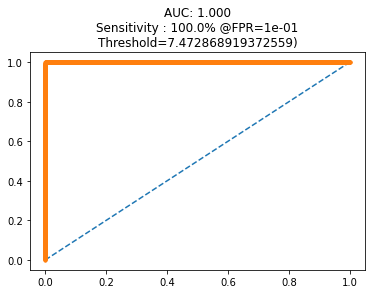

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.5468e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8967e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2172e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 4.3947e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9448e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.1093e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.1279e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 9.7101e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 6.7982e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 2.5906e-04
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3837e-04
Epoch 2/10
200/200 [==============================] -

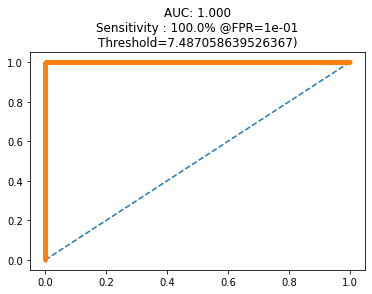

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1565e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 9.5724e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 9.3205e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 9.5641e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.7463e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8702e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 7.5300e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1820e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0061e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 7.7170e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 7.6004e-05
Epoch 2/10
200/200 [==============================] -

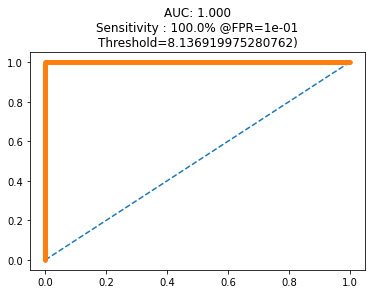

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 7.0528e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 8.4444e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1565e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 6.4530e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0700e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.1474e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7103e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7433e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 8.9378e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 8.9795e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 5.4894e-04
Epoch 2/10
200/200 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 14ms/step - loss: 7.5158e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6456e-04

 ------------- 

[-0.00199235 -0.138039   -0.00216645  0.00142326  0.00200568  0.00234039
  0.11343627 -0.2507786  -0.16653538 -0.12246554  0.10426858 -0.00269476
 -0.00295518 -0.09444588 -0.11933602 -0.21195072 -0.13803242 -0.07812586
  0.00185656  0.11449797  0.1011813   0.00298127 -0.11603681 -0.00306293
  0.12407856  0.00224934 -0.00299626  0.18419059  0.09432396  0.09875303
 -0.00115705  0.09541763 -0.00224863  0.00179538 -0.0022612   0.09075104
  0.26301694 -0.11641604  0.22083178 -0.1102669   0.13754973  0.11414884
  0.14870436 -0.00262959  0.00193744  0.1240557  -0.11514296  0.00227263
 -0.00294729  0.12800333  0.00248667  0.00313265  0.00156849 -0.11303283
 -0.00305992 -0.0944185  -0.101149    0.00304698 -0.19769928 -0.15945217
  0.10535342  0.00298122 -0.11481949 -0.11112677 -0.15630999 -0.1010683
 -0.00217313 -0.13

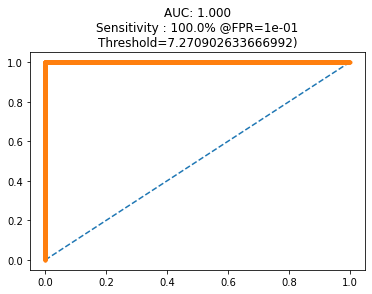

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 6.1529e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 5.4408e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 6.9173e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 6.8046e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0139e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3284e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 7.9329e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 1.9820e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6123e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9260e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 7.7957e-05
Epoch 2/10
200/200 [==============================] -

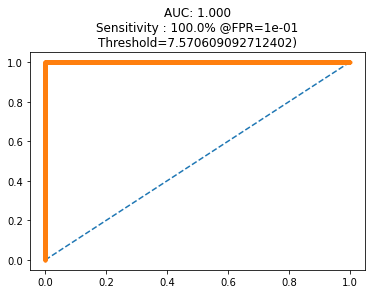

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5400e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.8016e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3485e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3550e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 2.4691e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 2.1728e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 5.7536e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3845e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0696e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 5.1203e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8461e-04
Epoch 2/10
200/200 [==============================] -

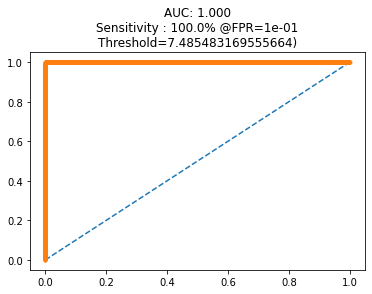

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1653e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 6.7206e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.1062e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 2.3394e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 6.2994e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 3.4691e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0236e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 3.7418e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 6.6488e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 5.1285e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.2279e-04
Epoch 2/10
200/200 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200/200 [==============================] - 3s 14ms/step - loss: 5.0731e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 5.9988e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4443e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 6.1890e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 3.0180e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.2206e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 8.1404e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.4217e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.2141e-04
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 6.1758e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 5.5839e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/st

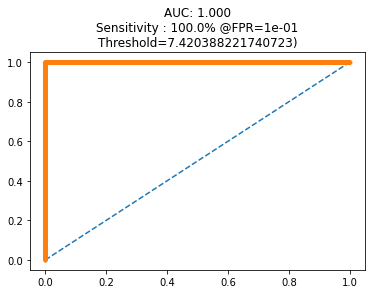

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0869e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8065e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1439e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 6.4961e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4290e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 7.0054e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 7.1110e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0457e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 4.5015e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1436e-04
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 6.6877e-05
Epoch 2/10
200/200 [==============================] -

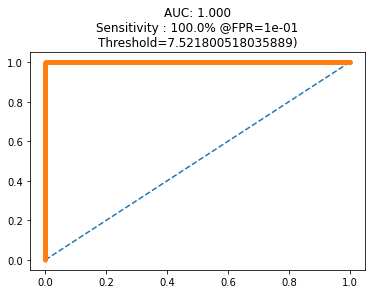

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 4.3895e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 5.7820e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 6.8455e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.6479e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 4.8587e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 4.3375e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5895e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 2.2057e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 4.7458e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 8.7000e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0414e-04
Epoch 2/10
200/200 [==============================] -

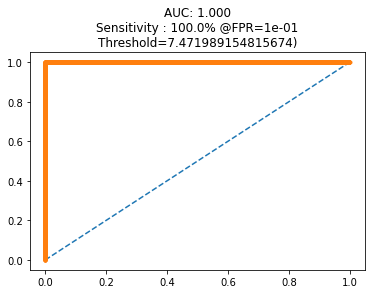

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 6.5263e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 4.4302e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0286e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.5390e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.2102e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 7.3326e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8128e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 7.4398e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3143e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 1.6517e-04
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 5.5420e-05
Epoch 2/10
200/200 [==============================] -

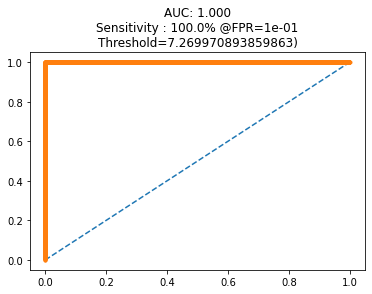

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7800e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 9.6714e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.3642e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 2.6890e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 7.8265e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 7.5460e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 2.5569e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 4.5514e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.4533e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 5.8866e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.5734e-04
Epoch 2/10
200/200 [==============================] -

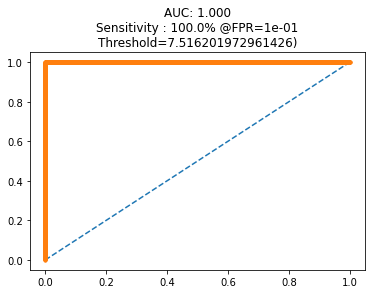

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.6967e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3138e-04
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 6.5603e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.4618e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8931e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 4.3571e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 3.7528e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 4.6643e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 6.0647e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 6.0288e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 5.5944e-05
Epoch 2/10
200/200 [==============================] -

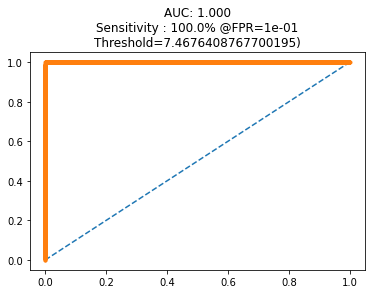

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.2529e-05
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 7.1573e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 4.2199e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0169e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9074e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0094e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6029e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3624e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9729e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 6.4615e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 4.6876e-05
Epoch 2/10
200/200 [==============================] -

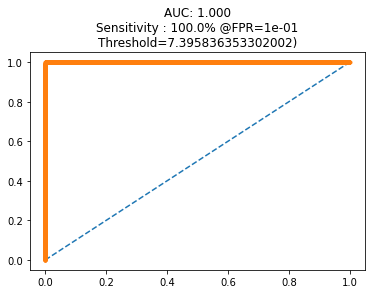

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6755e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3220e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7375e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7699e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.6411e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 5.0090e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 4.8488e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8472e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 8.0113e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 5.1729e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.0055e-04
Epoch 2/10
200/200 [==============================] -

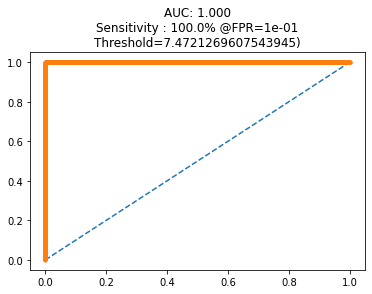

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 9.0324e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.9170e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 8.4031e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 6.2640e-05
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 3.9123e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 4.2931e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 3.8218e-05
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 3.8792e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 4.5505e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 1.5382e-04
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 4.2221e-04
Epoch 2/10
200/200 [==============================] -

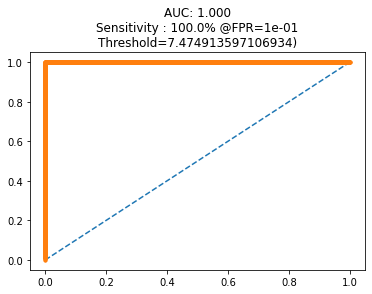

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 8.2633e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.4877e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.9971e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.4248e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.4361e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 9.1264e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0362e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 5.4529e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3097e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0234e-04
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8469e-04
Epoch 2/10
200/200 [==============================] -

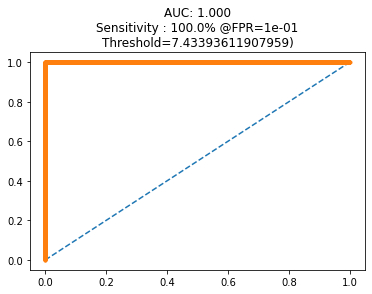

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.1279e-04
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.1402e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5906e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 6.0142e-05
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 1.0833e-04
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3025e-04
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 5.7093e-05
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 5.4084e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 5.0934e-05
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 6.2529e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.6215e-04
Epoch 2/10
200/200 [==============================] -

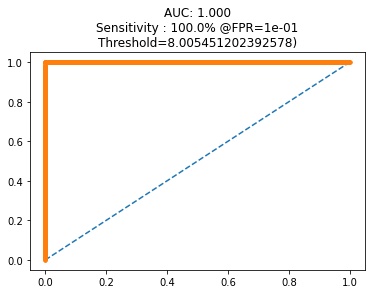

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 6.2594e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.0301e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5577e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 3.2740e-05
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 2.3699e-04
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 1.7002e-04
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 1.2727e-04
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 4.2193e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 2.9836e-04
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 1.6422e-04
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.2986e-04
Epoch 2/10
200/200 [==============================] -

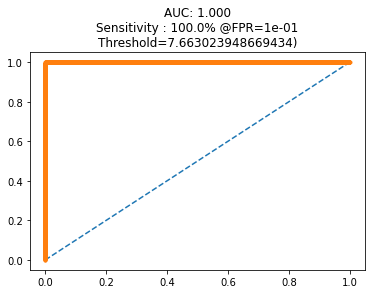

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.0757e-04
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 1.1204e-04
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5633e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 2.5222e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 1.7962e-04
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 5.2485e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 1.9439e-04
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 3.1072e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 4.1814e-05
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 9.2056e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 4.4019e-05
Epoch 2/10
200/200 [==============================] -

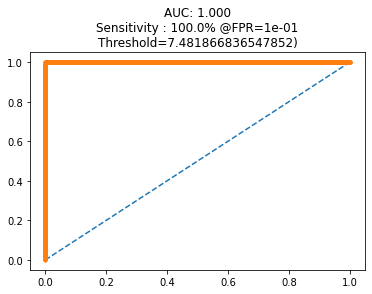

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 3.9462e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 2.6184e-04
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 1.4195e-04
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 3.6398e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 5.8373e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 3.6527e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 3.7848e-05
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 3.1043e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 4.2237e-05
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 5.8234e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.9647e-04
Epoch 2/10
200/200 [==============================] -

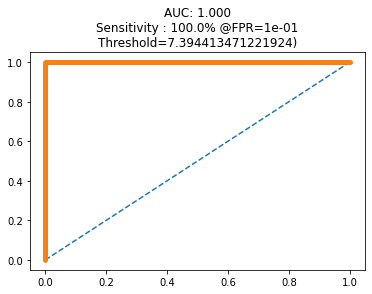

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 3.3006e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.2903e-04
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3787e-04
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 9.2986e-05
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 6.8925e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 4.7896e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 3.9840e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9132e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 3.8621e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 5.3653e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.6059e-05
Epoch 2/10
200/200 [==============================] -

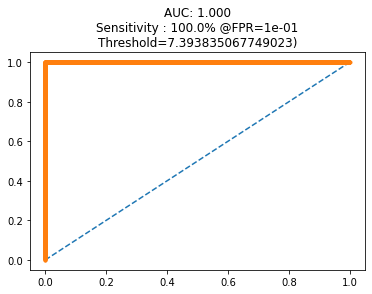

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 6.9991e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 4.8408e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.6276e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 3.4450e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0094e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 3.9406e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 5.6197e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 1.8081e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1215e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 6.8100e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.6366e-05
Epoch 2/10
200/200 [==============================] -

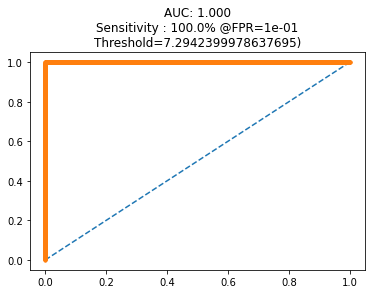

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.8281e-04
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 3.7179e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5646e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 2.7465e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 2.8287e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 3.9228e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 4.7622e-05
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 1.4839e-04
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5985e-05
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 3.0119e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 5.4078e-05
Epoch 2/10
200/200 [==============================] -

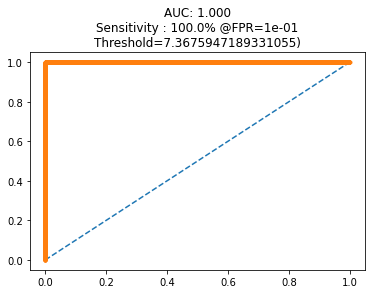

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.7146e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8258e-04
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 1.2644e-04
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 1.7913e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 9.4435e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 2.8369e-04
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 1.5660e-04
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 5.6085e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 1.2327e-04
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 3.5063e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 6.7975e-05
Epoch 2/10
200/200 [==============================] -

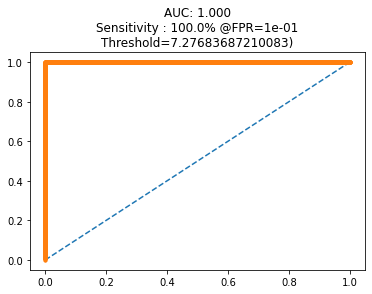

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 8.6088e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 7.4933e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 2.1977e-04
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 2.3469e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 2.9377e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 3.1080e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 3.3776e-05
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 4.6992e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 1.8929e-04
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3362e-04
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 3.7091e-05
Epoch 2/10
200/200 [==============================] -

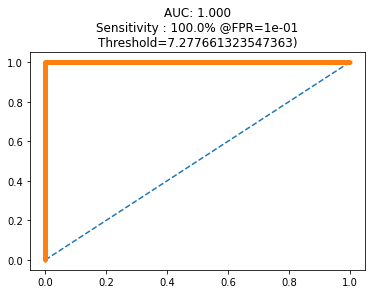

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 4.4278e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 4.3931e-05
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 4.0205e-05
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 1.1287e-04
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 6.9181e-05
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 5.6491e-05
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 1.4371e-04
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 5.8088e-05
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 5.9278e-04
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 3.2410e-05
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 3.3205e-05
Epoch 2/10
200/200 [==============================] -

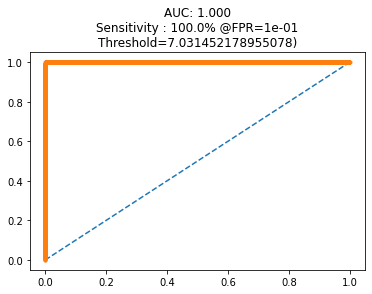

Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 4.1666e-05
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 2.6813e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 2.0549e-04
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 5.6980e-05
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 3.2378e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 1.8685e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6532e-05
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0466e-04
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 7.4752e-05
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 4.6709e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.3248e-05
Epoch 2/10
200/200 [==============================] -

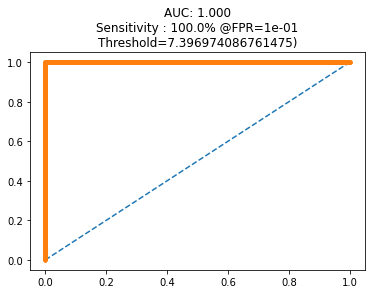

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 4.0103e-05
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 6.4042e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7027e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.8501e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 4.5209e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 3.4341e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0994e-04
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 3.8461e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1351e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 6.3098e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 4.1863e-05
Epoch 2/10
200/200 [==============================] -

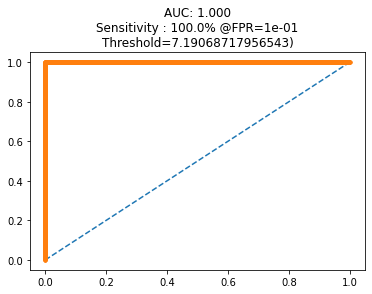

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.9115e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.6776e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7624e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9936e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9704e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 3.3394e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1857e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.3810e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.8597e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 4.5835e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7081e-04
Epoch 2/10
200/200 [==============================] -

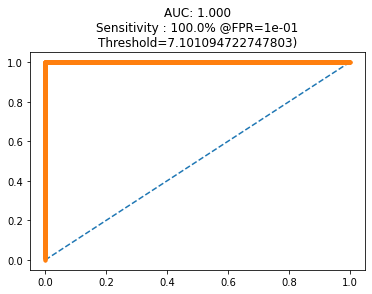

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8370e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7325e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 3.6360e-05
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 2.4174e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 1.6848e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 3.7249e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 6.5901e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.0317e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.9619e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 8.5956e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.5430e-05
Epoch 2/10
200/200 [==============================] -

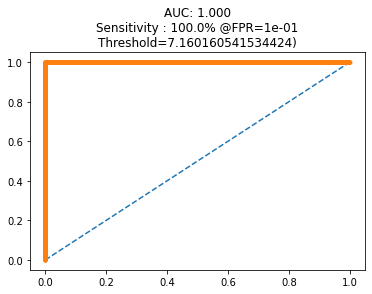

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0748e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0913e-04
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0520e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 2.1171e-04
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1411e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 6.8273e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 4.1059e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.0283e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9601e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2453e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.0982e-04
Epoch 2/10
200/200 [==============================] -

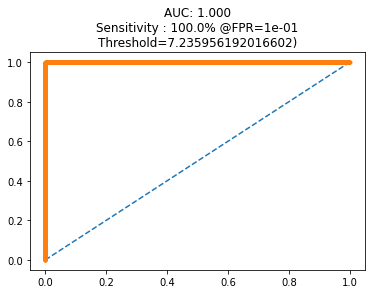

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3628e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 8.8056e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1757e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 3.5599e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.6287e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 4.8572e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 8.5683e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0674e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1825e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 3.6536e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6389e-05
Epoch 2/10
200/200 [==============================] -

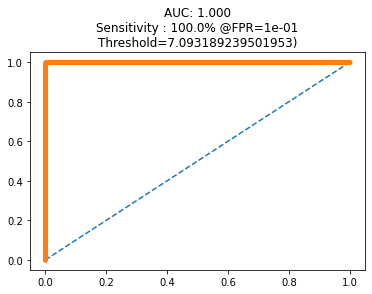

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 5.0370e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 4.1550e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 3.1997e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.5634e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 8.8539e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 5.1769e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7826e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 9.3285e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6025e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 5.2393e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7857e-05
Epoch 2/10
200/200 [==============================] -

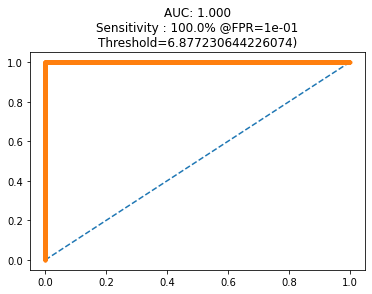

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.5958e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 3.0536e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 4.4233e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 3.0061e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.5708e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0511e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 9.4953e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5376e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3258e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 5.9071e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9104e-04
Epoch 2/10
200/200 [==============================] -

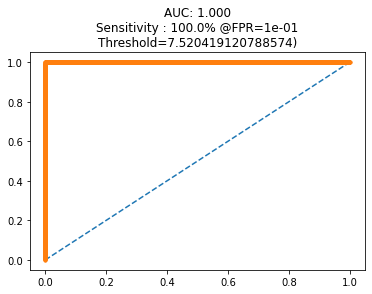

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 5.6183e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7371e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 6.5211e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7632e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.1571e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9815e-05
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0637e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7355e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9374e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 3.1859e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3347e-05
Epoch 2/10
200/200 [==============================] -

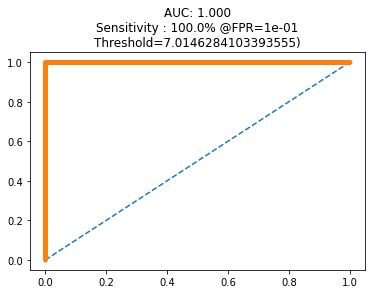

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0510e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6924e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9627e-05
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 7.8100e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.6808e-05
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 2.2584e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9125e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9945e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 2.3328e-04
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9669e-04
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 9.0599e-05
Epoch 2/10
200/200 [==============================] -

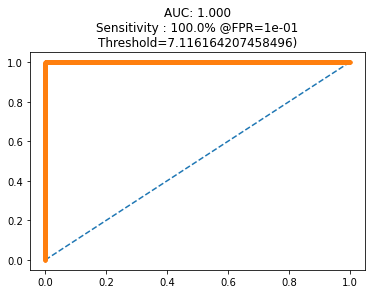

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4688e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 4.5088e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7046e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6825e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 3.8250e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7026e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1617e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.3922e-04
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 6.8569e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8232e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9757e-04
Epoch 2/10
200/200 [==============================] -

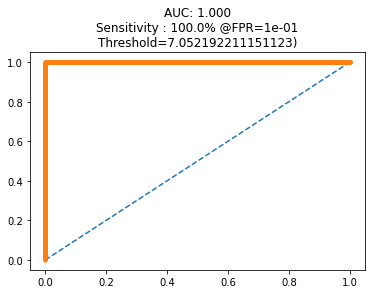

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 3.1205e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 3.4249e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 3.4368e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 4.8828e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0682e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2767e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5811e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 4.5775e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9930e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 4.3286e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.6064e-05
Epoch 2/10
200/200 [==============================] -

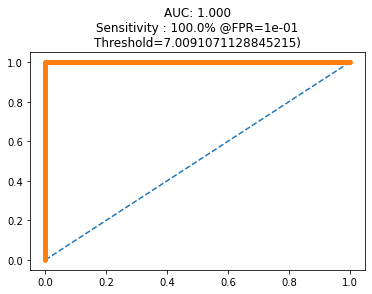

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.4197e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8570e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 4.9861e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 5.5237e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 3.9924e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 3.9564e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0635e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 6.5804e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 7.0221e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 5.3444e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7175e-04
Epoch 2/10
200/200 [==============================] -

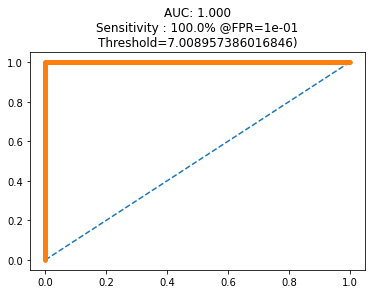

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7314e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 3.0826e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 3.2833e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 4.5827e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8508e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4115e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3008e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0162e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8514e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9949e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.4105e-04
Epoch 2/10
200/200 [==============================] -

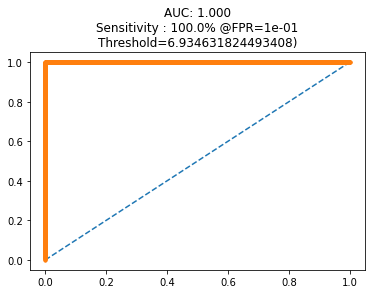

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 1.4114e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3718e-04
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.2569e-04
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 3.8160e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 8.7280e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1644e-04
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 6.7891e-05
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 1.5908e-04
Epoch 9/10
200/200 [==============================] - 4s 18ms/step - loss: 1.6285e-04
Epoch 10/10
200/200 [==============================] - 4s 20ms/step - loss: 4.3274e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 2.9617e-05
Epoch 2/10
200/200 [==============================] -

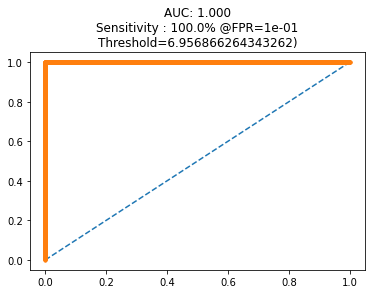

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9423e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3961e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 5.5283e-05
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 4.5943e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 4.2213e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4205e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8050e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8259e-04
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 2.2534e-04
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3221e-04
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 3.0536e-05
Epoch 2/10
200/200 [==============================] -

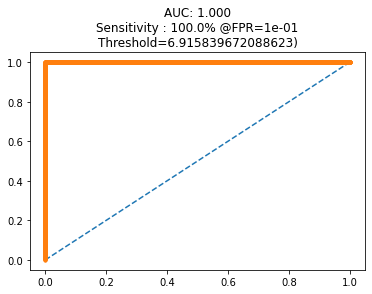

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 5.0626e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 4.1544e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 9.9887e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8692e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5790e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 4.1626e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7909e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 4.3826e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 8.3691e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 4.5478e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7925e-05
Epoch 2/10
200/200 [==============================] -

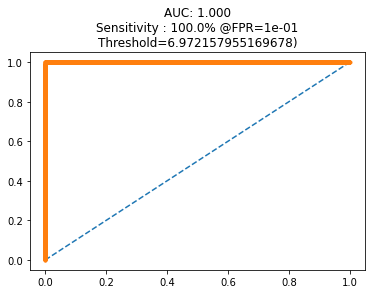

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3382e-05
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 7.2556e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 3.1487e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 1.7381e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1994e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9561e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5235e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7239e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8644e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6229e-04
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 4.5651e-05
Epoch 2/10
200/200 [==============================] -

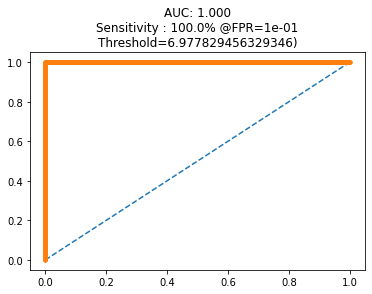

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9842e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 4.6730e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3754e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 1.2950e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3921e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 3.3411e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 4.2496e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.4072e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.8106e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.8263e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 2.2838e-05
Epoch 2/10
200/200 [==============================] -

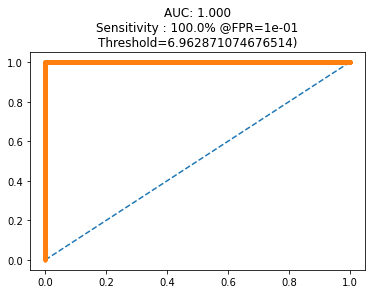

Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8550e-04
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 2.9474e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.7935e-05
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 9.8478e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.5767e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 2.8396e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 4.6096e-05
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 3.2273e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.0141e-04
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 3.4419e-05
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 2.8871e-05
Epoch 2/10
200/200 [==============================] -

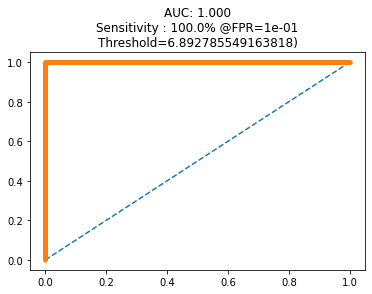

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9093e-05
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 2.5254e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3604e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 7.3989e-05
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8046e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0840e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 5.6889e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 4.8155e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 4.1411e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1777e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2930e-05
Epoch 2/10
200/200 [==============================] -

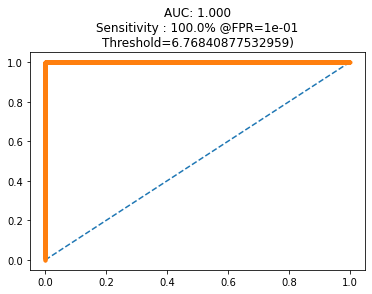

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 2.6925e-05
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4782e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 2.3486e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 3.1408e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 8.4767e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7551e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7966e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1969e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 4.4350e-04
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 3.0931e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0377e-04
Epoch 2/10
200/200 [==============================] -

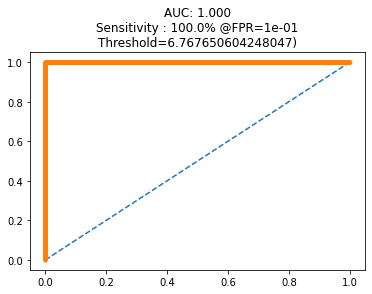

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 5.3662e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 2.7202e-04
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9265e-04
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 5.5352e-05
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 3.1065e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 3.2930e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.7509e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 4.2108e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7352e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 7.3863e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3747e-04
Epoch 2/10
200/200 [==============================] -

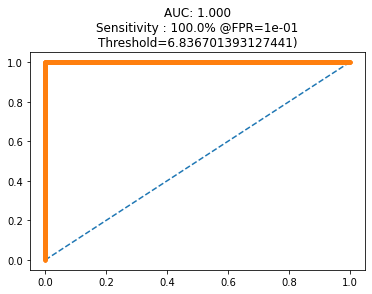

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.9883e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 2.0040e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 2.0045e-05
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8982e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 3.5922e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3719e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4637e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5515e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 3.0730e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 1.6120e-04
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 3.0754e-04
Epoch 2/10
200/200 [==============================] -

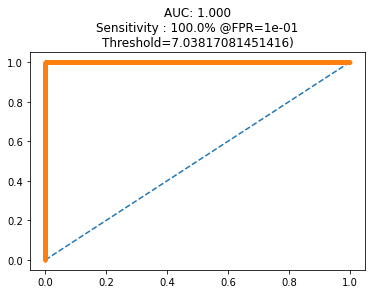

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3047e-04
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 7.5609e-05
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 2.3847e-05
Epoch 4/10
200/200 [==============================] - 4s 18ms/step - loss: 3.0483e-04
Epoch 5/10
200/200 [==============================] - 4s 18ms/step - loss: 7.6355e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 3.5781e-05
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 3.2012e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9409e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4882e-05
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 2.1924e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 3.2606e-05
Epoch 2/10
200/200 [==============================] -

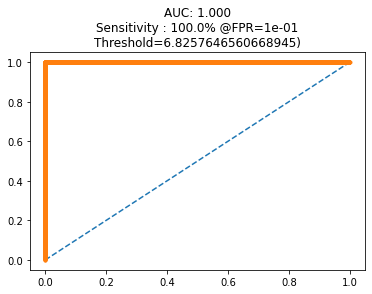

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0464e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9815e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1668e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 7.1611e-05
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 1.4099e-04
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 7.9639e-05
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 7.6917e-05
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 5.9808e-05
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 1.7688e-04
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 2.9368e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0246e-04
Epoch 2/10
200/200 [==============================] -

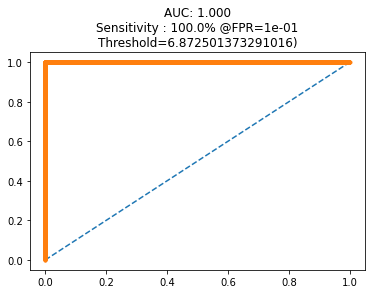

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8357e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0414e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 8.7894e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3567e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 3.8679e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 3.8180e-05
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 2.6207e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0215e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 1.4782e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9868e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 3.2964e-05
Epoch 2/10
200/200 [==============================] -

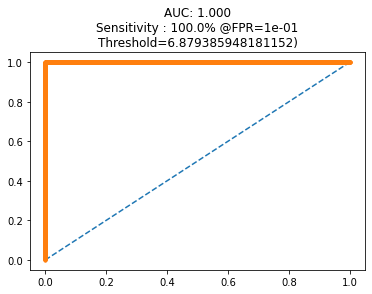

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 5.0248e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 4.8323e-05
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 3.3400e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5664e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9729e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5617e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3721e-05
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 3.4349e-05
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 3.7218e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8936e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 6.5980e-05
Epoch 2/10
200/200 [==============================] -

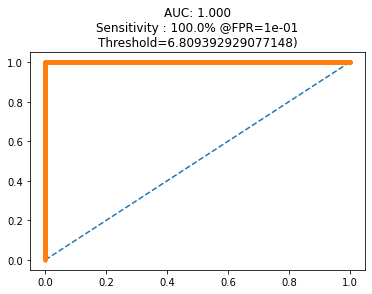

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 3.3728e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8111e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 5.0958e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3552e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8400e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1518e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0011e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 6.1754e-05
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 1.4157e-04
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9409e-04
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.5582e-04
Epoch 2/10
200/200 [==============================] -

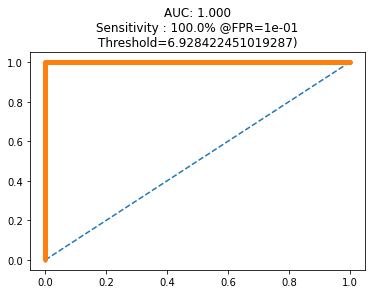

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.2519e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 4.7234e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 4.2593e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.7954e-05
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.5131e-04
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.3956e-04
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 1.7079e-04
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 4.0241e-05
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 1.9147e-05
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 2.4594e-05
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 4.7650e-05
Epoch 2/10
200/200 [==============================] -

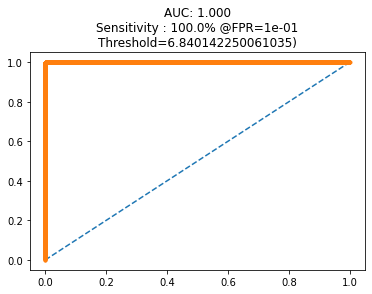

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.1341e-04
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 1.7524e-04
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 4.0589e-05
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8467e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 9.3795e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 4.7719e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.1082e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3831e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.9112e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.8643e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8257e-05
Epoch 2/10
200/200 [==============================] -

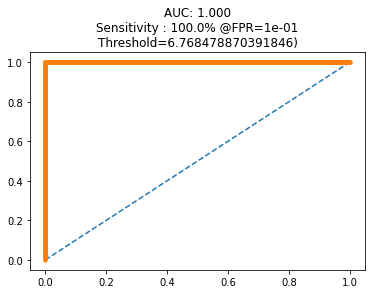

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 2.5792e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9343e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0032e-04
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 5.7543e-05
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 3.9131e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 3.1526e-04
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 3.4476e-05
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 2.5655e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2587e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0494e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3214e-05
Epoch 2/10
200/200 [==============================] -

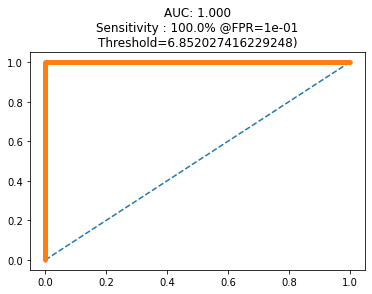

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2852e-05
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 1.4450e-04
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1521e-05
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 1.6395e-04
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 4.6627e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.9166e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1786e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1402e-04
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 4.1110e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5831e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6903e-05
Epoch 2/10
200/200 [==============================] -

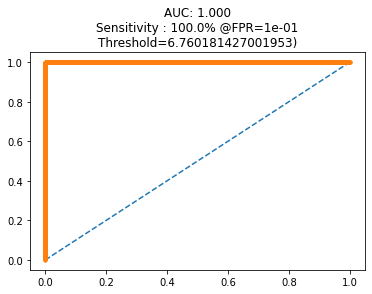

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 5.2889e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 2.2946e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 3.2818e-05
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 2.1300e-05
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9591e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 1.8270e-04
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 1.2365e-04
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3589e-04
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3013e-04
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0677e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.7870e-05
Epoch 2/10
200/200 [==============================] -

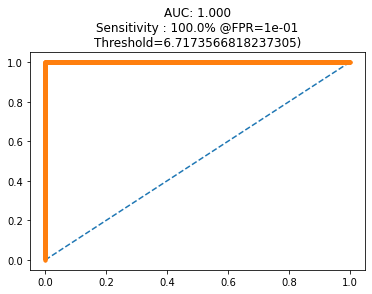

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6288e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 4.7151e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3568e-04
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 1.5809e-04
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 3.5814e-05
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9760e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 9.6214e-05
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 2.6516e-05
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 4.2202e-05
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 3.0354e-05
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 2.7567e-05
Epoch 2/10
200/200 [==============================] -

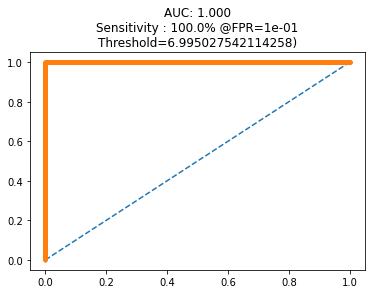

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 2.9802e-05
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0076e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7064e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 4.4906e-04
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 2.3557e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 2.3496e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4405e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6789e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 2.0264e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1444e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7053e-05
Epoch 2/10
200/200 [==============================] -

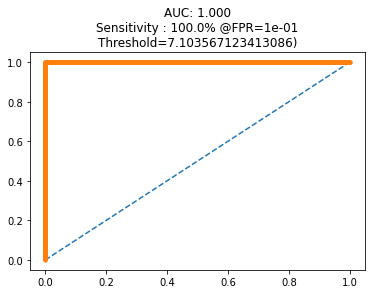

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 6.3954e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 2.0806e-05
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 2.2225e-05
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9395e-05
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 9.2059e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 1.7524e-04
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 3.1193e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.8351e-04
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 1.8570e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5132e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7676e-05
Epoch 2/10
200/200 [==============================] -

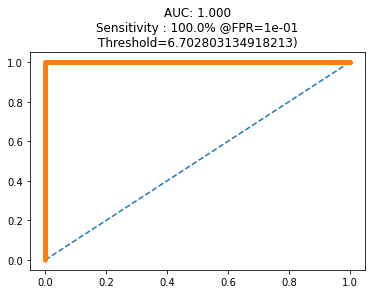

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.6703e-04
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 5.5399e-05
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 3.6243e-05
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 3.2498e-05
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 2.0420e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 3.4231e-04
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 2.0367e-05
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 1.8705e-04
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9158e-04
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 2.1128e-05
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.7577e-05
Epoch 2/10
200/200 [==============================] -

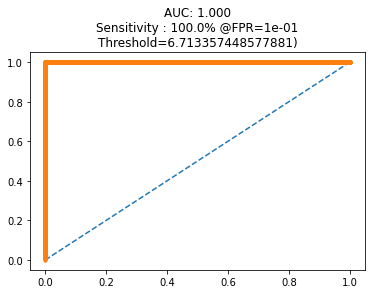

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2108e-05
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 1.7427e-04
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.8194e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4018e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.5527e-04
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 2.2436e-05
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7493e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 1.5433e-04
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 8.1524e-05
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 1.2546e-04
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 1.9248e-05
Epoch 2/10
200/200 [==============================] -

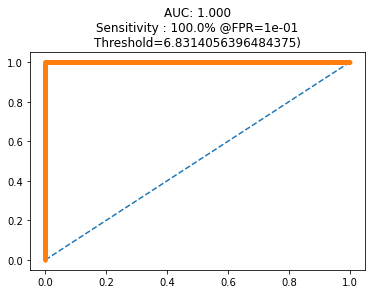

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0023e-04
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 5.5455e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3661e-04
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 6.5609e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5404e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7120e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8079e-05
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 2.6092e-05
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1415e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.5620e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1208e-05
Epoch 2/10
200/200 [==============================] -

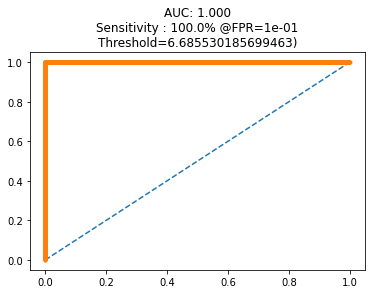

Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 2.2833e-05
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 1.8329e-04
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 2.2153e-05
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 2.1232e-05
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 2.7050e-05
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 5.2282e-05
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 2.4647e-04
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.5264e-04
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 8.2828e-05
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1029e-05
Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 4.1488e-05
Epoch 2/10
200/200 [==============================] -

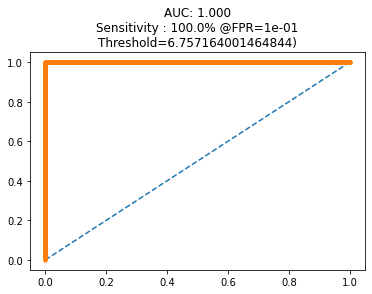

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 1.7225e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3068e-04
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 4.4264e-05
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 1.0509e-04
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 4.4235e-05
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 1.7304e-04
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 3.7503e-05
Epoch 8/10
200/200 [==============================] - 4s 18ms/step - loss: 3.9587e-05
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 2.0899e-05
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 2.4924e-05
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 8.8569e-05
Epoch 2/10
200/200 [==============================] -

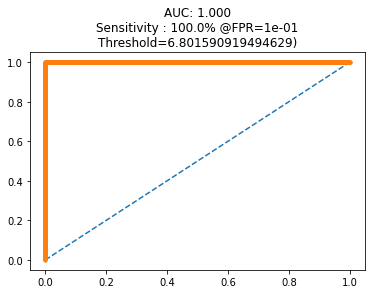

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 2.4329e-05
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 2.1979e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1519e-05
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 2.0192e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9507e-05
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 1.4464e-04
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 1.9641e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 2.6523e-05
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 1.9290e-05
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 4.2126e-05
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 1.6189e-04
Epoch 2/10
200/200 [==============================] -

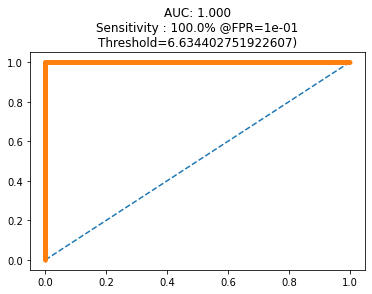

Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 2.0527e-05
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 2.0657e-05
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 7.5099e-05
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 2.5812e-05
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.3107e-04
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9855e-04
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.9904e-05
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 1.9980e-05
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 2.8613e-05
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1027e-05
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.4611e-04
Epoch 2/10
200/200 [==============================] -

In [ ]:
import time

def train_my_network():
    print("Starting training process!!")
    print("-------------------------------------")
    t_start = time.time()
    n_iteration=0
    #dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
    for i in range(1, n_iter+1):
      #  train_gen = get_triplet_batch_spoof(batch_size, X_train, Y_train, X_feature)
      #  val_gen = triplet_generator_spoof(batch_size, X_test, Y_test, X_test_feature)
      
        n_iteration += 1
        if i % 2 == 0:
            print("\n ------------- \n")
         #   print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
          #        .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
            probs, yprob = compute_probs(build_embedding, X_test[:1500,:,:,:,:], Y_test[:1500])
            fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
            draw_roc(fpr, tpr, thresholds, auc)
            
           # print("Probability " + str(probs))
           # print("YProbs " + str(yprob))
            #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
            #draw_roc(fpr, tpr)

train_my_network()

### Validation / Evaluation

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:5000,:,:,:,:], Y_train[:5000])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
labels_b = Y_test[Y_test==1]
labels_s = Y_test[Y_test==2]
X_test[labels_s.index].shape
y = labels_s.reset_index(drop=True)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_test[labels_s.index], y)
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:2500,:,:,:,:], Y_train[:2500])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
from sklearn.metrics import roc_auc_score

def power_mean(x, p=-5):
    return np.power(np.mean(np.power(x, p)),1/p)

def get_s_auc(y_true,y_pred,y_identity):
    mask = y_identity==1
    s_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return s_auc

def get_bpsn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==0) | (y_identity==0) & (y_true==1)
    bpsn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bpsn_auc

def get_bspn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==1) | (y_identity==0) & (y_true==0)
    bspn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bspn_auc

def get_total_auc(y_true,y_pred,y_identities):

    N = y_identities.shape[1]
    saucs = np.array([get_s_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bpsns = np.array([get_bpsn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bspns = np.array([get_bspn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])

    M_s_auc = power_mean(saucs)
    M_bpsns_auc = power_mean(bpsns)
    M_bspns_auc = power_mean(bspns)
    rauc = roc_auc_score(y_true,y_pred)


    total_auc = M_s_auc + M_bpsns_auc + M_bspns_auc + rauc
    total_auc/= 4

    return total_auc

In [ ]:
def DrawTestImage(network, images, refidx=500):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = list_of_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:1] = list_of_test[i][refidx,:,:,:1]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        #plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        plt.matshow(images[i,:,:,0], cmap='gray')
        #sns.heatmap(images[i,:,:,0], vmin=0, vmax=5000, cmap='Greens', center=None,
           #             robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
           #             cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
           #             yticklabels=True, mask=None, ax=None)
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            #plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            plt.matshow(ref_images[ref,:,:,0], vmin=0, vmax=200000, cmap='gray')
            #sns.heatmap(ref_images[ref,:,:,0].reshape(2,30).T, vmin=0, vmax=5000, cmap='Greens', center=None,
             #           robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
              #          cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
               #         yticklabels=True, mask=None, ax=None)
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][230,:,:,:,:],axis=0))

In [ ]:
#Full evaluation
probs,yprob = compute_probs(build_embedding,X_test,Y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding,n_iteration)

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][680,:,:,:],axis=0))

In [ ]:
checkpoint = ModelCheckpoint(model_cp_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]  # early

gen_tr = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)

history = triplet_model.fit_generator(gen_tr, 
                              epochs=10, 
                              verbose=1, 
                              workers=4,
                              steps_per_epoch=200, 
                              validation_steps=20, use_multiprocessing=True)

In [ ]:
train_preds  = []
train_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1, 1)
    predicts = triplet_model.predict(inputs)
    print(predicts[0])
    predicts = predicts.tolist()
    train_preds += predicts
    targets = targets.tolist()
    train_file_names += targets
train_preds = np.array(train_preds)


test_preds  = []
test_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1, 1)
    if i % evaluate_every == 0:
        predicts = embedding_model.predict(inputs)
        predicts = predicts.tolist()
        test_preds += predicts
        targets = targets.tolist()
        test_file_names += targets
test_preds = np.array(test_preds)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

In [ ]:
gen_te = triplet_generator_new(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
predictions = triplet_model.embedding_model.predict(gen_te, steps=1)
print(predictions)

In [ ]:
# plt.legend()
# plt.show()
def eva_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['loss'], label='Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_loss'], label='Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
eva_plot(history, 4)

def val_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['model_8_loss'], label='Embedding Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_model_8_loss'], label='Embedding Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
val_plot(history, 4) 

In [ ]:
def triplet_loss1(y_true, y_pred, alpha=0.4):
    print("for distance branch, y_pred.shape:  ", y_pred)       # [Batch_dim, vec_dim*3]

    vec_len = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, :int(vec_len/3)]
    positve = y_pred[:, int(vec_len/3):int(vec_len*2/3)]
    negative = y_pred[:, int(vec_len*2/3):]

    pos_dist = K.sum(K.square(anchor - positve), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(0., pos_dist - neg_dist + alpha)

    return loss
a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    y_true = (None, None, None)
    a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)
    print(a)
    p = tf.compat.v1.random_normal([5, 60], mean=1, stddev=1, seed = 1)
    n = tf.compat.v1.random_normal([5, 60], mean=3, stddev=4, seed = 1)
    merged = concatenate([a, p, n], axis=-1)
    y_pred = (tf.compat.v1.random_normal([3, 60], mean=6, stddev=0.1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=1, stddev=1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1), 
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1))
    loss = triplet_loss1(y_true, merged)
    
    print("loss = " + str(loss.eval()))


In [ ]:
evaluate_every = 20 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 2
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

  
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

In [ ]:
train_generator = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
val_generator = triplet_generator(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)

model.fit(generator=train_generator, steps_per_epoch=20, epochs=100,
                        validation_data=val_generator,
                        validation_steps=10,
                        verbose=1) #callbacks=[checkpoint])

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "val", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [ ]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

In [ ]:
# Reasons for Choices
Normalisation - https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
https://www.jeremyjordan.me/batch-normalization/